# Models to Combat Class Imbalance and Predict Pneumonia

In [98]:
import PIL
from PIL import Image
from PIL import ImageOps
from skimage import color
from skimage import io, transform
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import re
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import plotly.graph_objects as go

In [3]:
#function to check file names since pneumonia dataset is composed of viral and bacterial pneumonia
def separate_pneumonia(file_list):
    bacteria_list = []
    virus_list = []
    #regular expressions to search for word in file name
    bacteria = re.compile(r"bacteria")
    virus = re.compile(r"virus")
    for file in file_list:
        if bacteria.search(file):
            bacteria_list.append(file)
        elif virus.search(file):
            virus_list.append(file)
    return bacteria_list,virus_list
    
#define the paths for all training, testing, and validation data, both normal and pneumonia images

test_normal_path = r"C:\Users\Megan Finley\Documents\Fall2019\CSCI547_MachineLearning\Grad-Project\Data\chest_xray\test\NORMAL\\"
test_pneumonia_path = r"C:\Users\Megan Finley\Documents\Fall2019\CSCI547_MachineLearning\Grad-Project\Data\chest_xray\test\PNEUMONIA\\"

test_files_normal= os.listdir(test_normal_path)
test_files_pneumonia = os.listdir(test_pneumonia_path)
test_files_pneumonia_bacteria, test_files_pneumonia_virus = separate_pneumonia(test_files_pneumonia)

train_normal_path = r"C:\Users\Megan Finley\Documents\Fall2019\CSCI547_MachineLearning\Grad-Project\Data\chest_xray\train\NORMAL\\"
train_pneumonia_path = r"C:\Users\Megan Finley\Documents\Fall2019\CSCI547_MachineLearning\Grad-Project\Data\chest_xray\train\PNEUMONIA\\"

train_files_normal = os.listdir(train_normal_path)
train_files_pneumonia = os.listdir(train_pneumonia_path)
train_files_pneumonia_bacteria, train_files_pneumonia_virus = separate_pneumonia(train_files_pneumonia)


val_normal_path = r"C:\Users\Megan Finley\Documents\Fall2019\CSCI547_MachineLearning\Grad-Project\Data\chest_xray\val\NORMAL\\"
val_pneumonia_path = r"C:\Users\Megan Finley\Documents\Fall2019\CSCI547_MachineLearning\Grad-Project\Data\chest_xray\val\PNEUMONIA\\"

val_files_normal = os.listdir(val_normal_path)
val_files_pneumonia = os.listdir(val_pneumonia_path)

#initialize lists where array of converted image will be stored. Lists for normal and pneumonia will be combined later

#consider initializing as an array
test_normal=[]
test_pneumonia_bacteria = []
test_pneumonia_virus = []

train_normal = []
train_pneumonia_bacteria = []
train_pneumonia_virus = []

val_normal = []
val_pneumonia = []

#new height and width for images since all images are different sizes 
new_width  = 50
new_height = 50
inputs = new_width*new_height
N = 2

def read_in_image(path, file_list, new_width, new_height,flattened = False):
    image_list = []
    for image in file_list:
        size = (new_width,new_height)
        image = color.rgb2gray(io.imread(path + image))
        image = transform.resize(image, size, mode='constant')
        if flattened:
            image = image.flatten()
        image_list.append(image)
    return image_list

test_normal = read_in_image(test_normal_path,test_files_normal,new_width,new_height) 
print('Done')
test_pneumonia_bacteria = read_in_image(test_pneumonia_path,test_files_pneumonia_bacteria,new_width,new_height)
print('Done')
test_pneumonia_virus = read_in_image(test_pneumonia_path,test_files_pneumonia_virus,new_width,new_height)
print('Done')

train_normal = read_in_image(train_normal_path,train_files_normal,new_width,new_height) 
print('Done')
train_pneumonia_bacteria = read_in_image(train_pneumonia_path,train_files_pneumonia_bacteria,new_width,new_height)
print('Done')
train_pneumonia_virus = read_in_image(train_pneumonia_path,train_files_pneumonia_virus,new_width,new_height)
print('Done')

val_normal = read_in_image(val_normal_path,val_files_normal,new_width,new_height) 
print('Done')
val_pneumonia = read_in_image(val_pneumonia_path,val_files_pneumonia,new_width,new_height)
print('Done')

Done
Done
Done
Done
Done
Done
Done
Done


**Make Labels and Lists of the Data**

In [134]:
#consolidate lists and create y labels: 0 for normal 1 for pneumonia or 0 for normal, 1 for bacteria and 2 for virus
#length of lists for making y labels
tb = len(test_pneumonia_bacteria)
tv = len(test_pneumonia_virus)
tn = len(test_normal)
trb = len(train_pneumonia_bacteria)
trv = len(train_pneumonia_virus)
trn = len(train_normal)

x_test = []
x_test.extend(test_normal)
x_test.extend(test_pneumonia_bacteria) 
x_test.extend(test_pneumonia_virus)
x_test = np.array(x_test)

#initialize lists for various y_test data
y_test_2class = []
y_test_3class = []

y_test_normal = [0]*tn
y_test_pneumonia_bacteria = [1]*tb
y_test_pneumonia_virus = [2]*tv
y_test_pneumonia2 = [1]*(tv+tb)

#y_test if we treat data with 2 classes
y_test_2class.extend(y_test_normal)
y_test_2class.extend(y_test_pneumonia2)
y_test_2class = np.array(y_test_2class)

#y_test if we treat data with 3 classes
y_test_3class.extend(y_test_normal)
y_test_3class.extend(y_test_pneumonia_bacteria)
y_test_3class.extend(y_test_pneumonia_virus)
y_test_3class = np.array(y_test_3class)

x_train = []
x_train.extend(train_normal)
x_train.extend(train_pneumonia_bacteria) #len of training set:5216
x_train.extend(train_pneumonia_virus)
x_train = np.array(x_train)

#initailize lists for y_train data
y_train_2class = []
y_train_3class = []

y_train_normal = [0]*trn
y_train_pneumonia_bacteria = [1]*trb
y_train_pneumonia_virus = [2]*trv
y_train_pneumonia2 = [1]*(trb+trv)

#y_train if we have 2 classes
y_train_2class.extend(y_train_normal)
y_train_2class.extend(y_train_pneumonia2)
y_train_2class = np.array(y_train_2class)

#y_train if we have 3 classes
y_train_3class.extend(y_train_normal)
y_train_3class.extend(y_train_pneumonia_bacteria)
y_train_3class.extend(y_train_pneumonia_virus)
y_train_3class = np.array(y_train_3class)

x_val = []
x_val.extend(val_normal)
x_val.extend(val_pneumonia)
x_val = np.array(x_val)

y_val = []
y_val_normal = [0]*len(val_normal)
y_val_pneumonia = [1]*len(val_pneumonia)
y_val.extend(y_val_normal)
y_val.extend(y_val_pneumonia)
y_val = np.array(y_val)

In [135]:
#cast data to tensors and reshape data for cnn, cnn expects channels, we only have 1
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train_2class = torch.from_numpy(y_train_2class)
y_train_3class = torch.from_numpy(y_train_3class)
y_test_2class = torch.from_numpy(y_test_2class) 
y_test_3class = torch.from_numpy(y_test_3class) 
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

x_train = x_train.to(torch.float32)
x_train_2d = x_train.reshape(-1,1,50,50)#need channels for cnn
x_train_1d = x_train.reshape(-1,1,2500)
x_test = x_test.to(torch.float32)
x_test_2d = x_test.reshape(-1,1,50,50)#need channels for cnn
x_test_1d = x_test.reshape(-1,1,2500)
y_train_2class = y_train_2class.to(torch.long)
y_train_3class = y_train_3class.to(torch.long)
y_test_2class = y_test_2class.to(torch.long)
y_test_3class = y_test_3class.to(torch.long)

**Scaled Data**

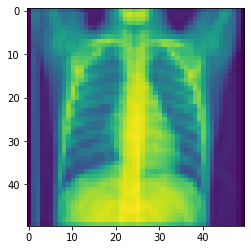

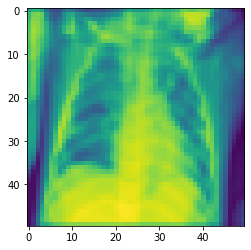

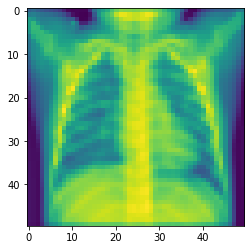

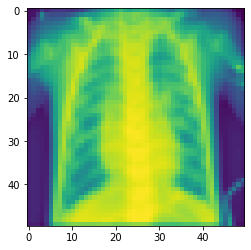

In [105]:
#what the images look like scaled down
plt.imshow(test_normal[100].reshape(50,50))
plt.show()
plt.imshow(test_pneumonia_bacteria[100].reshape(50,50))
plt.show()
plt.imshow(train_normal[100].reshape(50,50))
plt.show()
plt.imshow(train_pneumonia_virus[100].reshape(50,50))
plt.show()


# 1D Convolutional Neural Networks for 2 and 3 Class Data

In [200]:
#data for 2 and 3 class
training_data_2class = TensorDataset(x_train_1d,y_train_2class)
test_data_2class = TensorDataset(x_test_1d,y_test_2class)
training_data_3class = TensorDataset(x_train_1d,y_train_3class)
test_data_3class = TensorDataset(x_test_1d,y_test_3class)

batch_size = 64
train_loader_2class = torch.utils.data.DataLoader(dataset=training_data_2class,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 64
test_loader_2class = torch.utils.data.DataLoader(dataset=test_data_2class,
                                           batch_size=batch_size, 
                                           shuffle=False)
batch_size = 64
train_loader_3class = torch.utils.data.DataLoader(dataset=training_data_3class,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 64
test_loader_3class = torch.utils.data.DataLoader(dataset=test_data_3class,
                                           batch_size=batch_size, 
                                           shuffle=False)

**CNN Using Only Dropout for 2 Class**

In [162]:
class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters and functions.
        Here, we instantiate 2 1D convolution layers and 2 max pooling layers
        """
        super(Net,self).__init__()
        self.conv1= nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1) #takes 3 input and outputs 16 
        #features, kernel width of 3 takes moving average, padding adds zeros to the boundary
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2) #2x2 kernel skips two pixels everytime

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, padding=1)#takes 16 inputs (outputs 
        #from previous layer) outputs 64 features
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)


        self.l1 = nn.Linear(40000,128) #128 size of hidden layers
        self.l2 = nn.Linear(128,64)
        self.l3 = nn.Linear(64,2) # number of classes

        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.dropout_3 = nn.Dropout(p=0.2)

    def forward(self,x):
        """
        This method runs the feedforward neural network.  
        """
        
        # Apply convolution
        a1 = self.conv1(x)
        
        # Apply activation function
        z1 = torch.relu(a1)
        
        # Apply max pooling
        z1 = self.pool1(z1)
                
        a2 = self.conv2(z1)
        z2 = torch.relu(a2)
        z2 = self.pool2(z2)      
             
        
        # Flatten the array we created 40000 new features
        z_flat = self.dropout_1(torch.reshape(z2,(-1,40000)))
        
        # Apply linear transformation
        a3 = self.l1(z_flat)
        z3 = self.dropout_2(torch.relu(a3)) #applying dropout
        
        a4 = self.l2(a3)
        z4 = self.dropout_3(torch.relu(a4))
        
        a5 = self.l3(z4)
        
        return a5

In [163]:
#below will train a model and compare accuracies for data for 2 class data
model_2class = Net()
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model_2class.parameters())

train_accs_2class = []
test_accs_2class = []

epochs = 50
# Loop over the data
for epoch in range(epochs):
    model_2class.train()
    # Loop over each subset of data
    for d,t in train_loader_2class:
        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()        
        # Make a prediction based on the model
        outputs = model_2class(d)        
        # Compute the loss
        loss = criterion(outputs,t)      
        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()   
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model_2class.eval()
    total_2class=0.
    correct_2class=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader_2class:
        outputs = model_2class(d)
        _, predicted = torch.max(outputs.data,1)
        total_2class += float(t.size(0))
        correct_2class += float((predicted==t).sum())
    total_train_2class = 0
    correct_train_2class = 0
    for d,t in train_loader_2class:
        outputs = model_2class(d)
        _, predicted = torch.max(outputs.data,1)
        total_train_2class += float(t.size(0))
        correct_train_2class += float((predicted==t).sum())
    
    # Print the epoch, the training loss, and the test set accuracy.
    train_accs_2class.append(100.*correct_train_2class/total_train_2class)
    test_accs_2class.append(100.*correct_2class/total_2class)
    
    print(epoch,loss.item(),train_accs_2class[-1],test_accs_2class[-1])


0 0.23375889658927917 94.09509202453988 80.76923076923077
1 0.02899259515106678 95.82055214723927 79.00641025641026
2 0.196255624294281 96.52990797546012 74.19871794871794
3 0.20480027794837952 96.79831288343559 75.0
4 0.043313074856996536 97.71855828220859 77.56410256410257
5 0.10896435379981995 97.2967791411043 73.87820512820512
6 0.07650396227836609 97.795245398773 75.96153846153847
7 0.016804752871394157 98.10199386503068 75.16025641025641
8 0.008602779358625412 98.37039877300613 75.96153846153847
9 0.030338479205965996 98.52377300613497 76.6025641025641
10 0.06316010653972626 98.73466257668711 78.2051282051282
11 0.010932722128927708 99.0989263803681 77.88461538461539
12 0.013965708203613758 98.71549079754601 72.11538461538461
13 0.020256120711565018 99.21395705521472 75.0
14 0.06900846213102341 99.44401840490798 77.40384615384616
15 0.033697888255119324 99.1180981595092 73.87820512820512
16 0.005060783587396145 98.52377300613497 72.59615384615384
17 0.008431880734860897 99.712423

**CNN Using Only Dropout for 3 Class**

In [164]:
#same as model above, now we have 3 outputs instead of 2
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1= nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2) #2x2 kernel skips two pixels everytime

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)


        self.l1 = nn.Linear(40000,128) #128 size of hidden layers
        self.l2 = nn.Linear(128,64)
        self.l3 = nn.Linear(64,3) # number of classes

        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.dropout_3 = nn.Dropout(p=0.2)

    def forward(self,x):
       
        a1 = self.conv1(x)
        
        z1 = torch.relu(a1)
        
        z1 = self.pool1(z1)
                
        a2 = self.conv2(z1)
        z2 = torch.relu(a2)
        z2 = self.pool2(z2)  
             
        
        z_flat = self.dropout_1(torch.reshape(z2,(-1,40000)))
        
        a3 = self.l1(z_flat)
        z3 = self.dropout_2(torch.relu(a3))
        
        a4 = self.l2(a3)
        z4 = self.dropout_3(torch.relu(a4))
        
        a5 = self.l3(z4)
        
        return a5

In [165]:
#model to train for 3 class data
model_3class = Net()
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model_3class.parameters())

train_accs_3class = []
test_accs_3class = []

epochs = 50
for epoch in range(epochs):
    model_3class.train()
    
    for d,t in train_loader_3class:
        optimizer.zero_grad()        
        outputs = model_3class(d)        
        loss = criterion(outputs,t)
        loss.backward()        
        optimizer.step()
        
    model_3class.eval()
    total_3class=0.
    correct_3class=0.
    for d,t in test_loader_3class:
        outputs = model_3class(d)
        _, predicted = torch.max(outputs.data,1)
        total_3class += float(t.size(0))
        correct_3class += float((predicted==t).sum())
    total_train_3class = 0
    correct_train_3class = 0
    for d,t in train_loader_3class:
        outputs = model_3class(d)
        _, predicted = torch.max(outputs.data,1)
        total_train_3class += float(t.size(0))
        correct_train_3class += float((predicted==t).sum())
    train_accs_3class.append(100.*correct_train_3class/total_train_3class)
    test_accs_3class.append(100.*correct_3class/total_3class)
    
    print(epoch,loss.item(),train_accs_3class[-1],test_accs_3class[-1])


0 0.5701451897621155 74.82745398773007 77.08333333333333
1 0.6044983267784119 74.65490797546012 61.37820512820513
2 0.6048632264137268 76.95552147239263 66.50641025641026
3 0.5064146518707275 75.4792944785276 76.12179487179488
4 0.4492485821247101 78.1441717791411 69.07051282051282
5 0.34143325686454773 79.54371165644172 72.43589743589743
6 0.524314284324646 80.98159509202453 69.39102564102564
7 0.37264686822891235 81.17331288343559 67.78846153846153
8 0.32770705223083496 82.32361963190183 67.46794871794872
9 0.41434669494628906 81.74846625766871 64.90384615384616
10 0.5138119459152222 83.18634969325153 74.35897435897436
11 0.4333680272102356 83.9340490797546 73.5576923076923
12 0.31556054949760437 85.54447852760737 68.42948717948718
13 0.61856609582901 85.83205521472392 69.71153846153847
14 0.29961180686950684 85.60199386503068 73.07692307692308
15 0.36907434463500977 87.11656441717791 66.18589743589743
16 0.23690387606620789 88.09432515337423 70.67307692307692
17 0.22862248122692108 

**Evaluation of Models and Summary Stats**

In [171]:
#Confusion matrix for 2 classes
y_pred_2class = np.argmax(model_2class(x_test_1d).cpu().detach(),axis=1)
y_test_cpu_2class = y_test_2class.cpu()

cm1 = confusion_matrix(y_pred_2class,y_test_cpu_2class)
precision1 = np.diag(cm1)/cm1.sum(axis=1)
recall1 = np.diag(cm1)/cm1.sum(axis=0)
print('precision:',precision1)
print('recall:',recall1)
print(cm1)

#confusion matrix for 3 classes
y_pred_3class = np.argmax(model_3class(x_test_1d).cpu().detach(),axis=1)
y_test_cpu_3class = y_test_3class.cpu()

cm2 = confusion_matrix(y_pred_3class,y_test_cpu_3class)
precision2 = np.diag(cm2)/cm2.sum(axis=1)
recall2 = np.diag(cm2)/cm2.sum(axis=0)
print('precision:',precision2)
print('recall:',recall2)
print(cm2)

#plots for training and testing accuracy for 2 and 3 class compared
x = [x for x in range(0,50)]
fig = go.Figure()
fig.add_trace(go.Scatter(x =x,y=train_accs_2class,mode = 'lines+markers',name = 'Training'))
fig.add_trace(go.Scatter(x =x,y=test_accs_2class,mode = 'lines+markers',name = 'Testing'))
fig.update_layout(title_text = 'Accuracy Rates for 2 Class Pneumonia Classification')
fig.update_xaxes(title_text = 'Epoch')
fig.update_yaxes(title_text = 'Accuracy Rate')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x =x,y=train_accs_3class,mode = 'lines+markers',name = 'Training'))
fig.add_trace(go.Scatter(x =x,y=test_accs_3class,mode = 'lines+markers',name = 'Testing'))
fig.update_layout(title_text = 'Accuracy Rates for 3 Class Pneumonia Classification')
fig.update_xaxes(title_text = 'Epoch')
fig.update_yaxes(title_text = 'Accuracy Rate')
fig.show()

precision: [0.97272727 0.75291829]
recall: [0.45726496 0.99230769]
[[107   3]
 [127 387]]
precision: [0.97169811 0.76190476 0.49107143]
recall: [0.44017094 0.92561983 0.74324324]
[[103   3   0]
 [ 32 224  38]
 [ 99  15 110]]


**CNN Using Dropout and L2 Regularization for 2 Class**

In [201]:
#this model is the same as the ones above
class Net(nn.Module):
    def __init__(self):
       
        super(Net,self).__init__()
        self.conv1= nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2) 

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)


        self.l1 = nn.Linear(40000,128) #128 size of hidden layers
        self.l2 = nn.Linear(128,64)
        self.l3 = nn.Linear(64,2) # number of classes

        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.dropout_3 = nn.Dropout(p=0.2)

    def forward(self,x):

        a1 = self.conv1(x)
        
        z1 = torch.relu(a1)
        
        z1 = self.pool1(z1)
                
        a2 = self.conv2(z1)
        z2 = torch.relu(a2)
        z2 = self.pool2(z2)      
             
        
        z_flat = self.dropout_1(torch.reshape(z2,(-1,40000)))
        
        a3 = self.l1(z_flat)
        z3 = self.dropout_2(torch.relu(a3))
        
        a4 = self.l2(a3)
        z4 = self.dropout_3(torch.relu(a4))
        
        a5 = self.l3(z4)
        
        return a5

In [202]:
#below will train a model and compare accuracies for data for 2 class data using dropout and L2 regularization
model_2class = Net()
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model_2class.parameters())

train_accs_2class = []
test_accs_2class = []

gamma = 2e3 #regularization term how much we applify the penalty

epochs = 50
# Loop over the data
for epoch in range(epochs):
    model_2class.train()
    # Loop over each subset of data
    for d,t in train_loader_2class:
        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()        
        # Make a prediction based on the model
        outputs = model_2class(d)        
        # Compute the loss
        loss = criterion(outputs,t)    
        #regularization  
        for p in model.parameters():
            if p.dim()>1:
                loss += gamma/(2*d.shape[0])*(p**2).sum() #formula for the L2 norm will penalize large weights
        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()   
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model_2class.eval()
    total_2class=0.
    correct_2class=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader_2class:
        outputs = model_2class(d)
        _, predicted = torch.max(outputs.data,1)
        total_2class += float(t.size(0))
        correct_2class += float((predicted==t).sum())
    total_train_2class = 0
    correct_train_2class = 0
    for d,t in train_loader_2class:
        outputs = model_2class(d)
        _, predicted = torch.max(outputs.data,1)
        total_train_2class += float(t.size(0))
        correct_train_2class += float((predicted==t).sum())
    
    # Print the epoch, the training loss, and the test set accuracy.
    train_accs_2class.append(100.*correct_train_2class/total_train_2class)
    test_accs_2class.append(100.*correct_2class/total_2class)
    
    print(epoch,loss.item(),train_accs_2class[-1],test_accs_2class[-1])


0 1616792960.0 92.8680981595092 80.76923076923077
1 1616792960.0 95.49463190184049 81.73076923076923
2 1616792960.0 95.68634969325153 73.5576923076923
3 1616792960.0 96.64493865030674 75.16025641025641
4 1616792960.0 97.45015337423312 76.6025641025641
5 1616792960.0 97.62269938650307 78.2051282051282
6 1616792960.0 96.97085889570552 74.03846153846153
7 1616792960.0 97.85276073619632 81.41025641025641
8 1616792960.0 98.33205521472392 74.83974358974359
9 1616792960.0 98.37039877300613 74.35897435897436
10 1616792960.0 98.44708588957056 74.67948717948718
11 1616792960.0 99.15644171779141 76.92307692307692
12 1616792960.0 98.00613496932516 81.73076923076923
13 1616792960.0 98.37039877300613 83.33333333333333
14 1616792960.0 99.61656441717791 76.12179487179488
15 1616792960.0 99.63573619631902 75.96153846153847
16 1616792960.0 99.5782208588957 76.92307692307692
17 1616792960.0 99.63573619631902 77.72435897435898
18 1616792960.0 99.61656441717791 73.5576923076923
19 1616792960.0 99.079754601

**CNN Using Dropout and L2 Regularization for 3 Class**

In [207]:
#same as models above
class Net(nn.Module):
    def __init__(self):
       
        super(Net,self).__init__()
        self.conv1= nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2) 

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)


        self.l1 = nn.Linear(40000,128) 
        self.l2 = nn.Linear(128,64)
        self.l3 = nn.Linear(64,3) 
        
        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.dropout_3 = nn.Dropout(p=0.2)

    def forward(self,x):

        a1 = self.conv1(x)
        
        z1 = torch.relu(a1)
        
        z1 = self.pool1(z1)
                
        a2 = self.conv2(z1)
        z2 = torch.relu(a2)
        z2 = self.pool2(z2)      
             
        
        z_flat = self.dropout_1(torch.reshape(z2,(-1,40000)))
        
        a3 = self.l1(z_flat)
        z3 = self.dropout_2(torch.relu(a3))
        
        a4 = self.l2(a3)
        z4 = self.dropout_3(torch.relu(a4))
        
        a5 = self.l3(z4)
        
        return a5

In [204]:
#model to train for 3 class data
#same algorithm we used above for the two class
model_3class = Net()
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model_3class.parameters())

train_accs_3class = []
test_accs_3class = []

gamma = 2e3

epochs = 100
for epoch in range(epochs):
    model_3class.train()
    for d,t in train_loader_3class:
        optimizer.zero_grad()        
        outputs = model_3class(d)        
        loss = criterion(outputs,t)
        for p in model.parameters():
            if p.dim()>1:
                loss += gamma/(2*d.shape[0])*(p**2).sum()
        loss.backward()        
        optimizer.step()
        
    model_3class.eval()
    total_3class=0.
    correct_3class=0.
    for d,t in test_loader_3class:
        outputs = model_3class(d)
        _, predicted = torch.max(outputs.data,1)
        total_3class += float(t.size(0))
        correct_3class += float((predicted==t).sum())
    total_train_3class = 0
    correct_train_3class = 0
    for d,t in train_loader_3class:
        outputs = model_3class(d)
        _, predicted = torch.max(outputs.data,1)
        total_train_3class += float(t.size(0))
        correct_train_3class += float((predicted==t).sum())
    train_accs_3class.append(100.*correct_train_3class/total_train_3class)
    test_accs_3class.append(100.*correct_3class/total_3class)
    
    print(epoch,loss.item(),train_accs_3class[-1],test_accs_3class[-1])


0 1616792960.0 65.93174846625767 74.35897435897436
1 1616792960.0 75.78604294478528 69.39102564102564
2 1616792960.0 78.22085889570552 72.27564102564102
3 1616792960.0 79.12193251533742 67.46794871794872
4 1616792960.0 79.25613496932516 67.46794871794872
5 1616792960.0 77.91411042944786 61.53846153846154
6 1616792960.0 79.96549079754601 74.19871794871794
7 1616792960.0 80.94325153374233 67.78846153846153
8 1616792960.0 81.28834355828221 66.34615384615384
9 1616792960.0 76.57208588957056 56.57051282051282
10 1616792960.0 81.6909509202454 67.78846153846153
11 1616792960.0 82.87960122699387 72.91666666666667
12 1616792960.0 84.75843558282209 68.91025641025641
13 1616792960.0 85.41027607361963 67.94871794871794
14 1616792960.0 84.68174846625767 64.90384615384616
15 1616792960.0 86.80981595092024 65.38461538461539
16 1616792960.0 85.75536809815951 73.5576923076923
17 1616792960.0 86.1579754601227 67.94871794871794
18 1616792960.0 88.3627300613497 66.18589743589743
19 1616792960.0 89.6855828

**Evaluation of Model and Summary Stats**

In [206]:
#Confusion matrix for 2 classes
y_pred_2class = np.argmax(model_2class(x_test_1d).cpu().detach(),axis=1)
y_test_cpu_2class = y_test_2class.cpu()

cm1 = confusion_matrix(y_pred_2class,y_test_cpu_2class)
precision1 = np.diag(cm1)/cm1.sum(axis=1)
recall1 = np.diag(cm1)/cm1.sum(axis=0)
print('precision:',precision1)
print('recall:',recall1)
print(cm1)

#confusion matrix for 3 classes
y_pred_3class = np.argmax(model_3class(x_test_1d).cpu().detach(),axis=1)
y_test_cpu_3class = y_test_3class.cpu()

cm2 = confusion_matrix(y_pred_3class,y_test_cpu_3class)
precision2 = np.diag(cm2)/cm2.sum(axis=1)
recall2 = np.diag(cm2)/cm2.sum(axis=0)
print('precision:',precision2)
print('recall:',recall2)
print(cm2)

#plots for training and testing accuracy for 2 and 3 class compared
x = [x for x in range(0,50)]
fig = go.Figure()
fig.add_trace(go.Scatter(x =x,y=train_accs_2class,mode = 'lines+markers',name = 'Training'))
fig.add_trace(go.Scatter(x =x,y=test_accs_2class,mode = 'lines+markers',name = 'Testing'))
fig.update_layout(title_text = 'Accuracy Rates for 2 Class Pneumonia Classification')
fig.update_xaxes(title_text = 'Epoch')
fig.update_yaxes(title_text = 'Accuracy Rate')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x =x,y=train_accs_3class,mode = 'lines+markers',name = 'Training'))
fig.add_trace(go.Scatter(x =x,y=test_accs_3class,mode = 'lines+markers',name = 'Testing'))
fig.update_layout(title_text = 'Accuracy Rates for 3 Class Pneumonia Classification')
fig.update_xaxes(title_text = 'Epoch')
fig.update_yaxes(title_text = 'Accuracy Rate')
fig.show()

precision: [0.98550725 0.7009009 ]
recall: [0.29059829 0.9974359 ]
[[ 68   1]
 [166 389]]
precision: [0.95454545 0.66477273 0.48148148]
recall: [0.44871795 0.96694215 0.52702703]
[[105   2   3]
 [ 51 234  67]
 [ 78   6  78]]


**Data Augmentation**

In [180]:
# scaling between 90% and 110%, and a 10 degree shear over the x-axis) 
#20 defines bound of rotation
#translate takes relative sizes to which we shift
#scale provides bounds on degree to which zoom in or out
#this function will be used when we define batch sizes
transform = transforms.RandomAffine(20,translate=(0.1,0.1),scale=(0.8,1.1),shear=10)

# Custom dataset object
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        #will pass in the transform argument when we want to produce transformed data

        x = self.tensors[0][index]

        if self.transform:
            # reshape data, apply transform
            x = x.reshape((50,50))
            x = transforms.ToPILImage()(x)
            x = self.transform(x)
            x = transforms.ToTensor()(x)         

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


In [181]:
#create batches for the model, this time we apply transformations to help with overfitting
training_data_2class = CustomTensorDataset([x_train_2d,y_train_2class],transform=transform)
test_data_2class = CustomTensorDataset([x_test_2d,y_test_2class])
training_data_3class = CustomTensorDataset([x_train_2d,y_train_3class],transform=transform)
test_data_3class = CustomTensorDataset([x_test_2d,y_test_3class])

batch_size = 64
train_loader_2class = torch.utils.data.DataLoader(dataset=training_data_2class,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 64
test_loader_2class = torch.utils.data.DataLoader(dataset=test_data_2class,
                                           batch_size=batch_size, 
                                           shuffle=False)

batch_size = 64
train_loader_3class = torch.utils.data.DataLoader(dataset=training_data_3class,
                                           batch_size=batch_size, 
                                           shuffle=True) 

batch_size = 64
test_loader_3class = torch.utils.data.DataLoader(dataset=test_data_3class,
                                           batch_size=batch_size, 
                                           shuffle=False)

**CNN Using Dropout, L2 Regularization and Data Augmentation for 2 Class**

In [194]:
#using a 2D cnn because applying the transform changed the nature of data
#I tried using 1D but there were dimension issues, 2D fixed the problem
class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters and functions.
        Here, we instantiate 2 2D convolution layers and 2 max pooling layers
        """
        super(Net,self).__init__()
        self.conv1= nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1) #takes 1 channel input and outputs 
        #16 features, kernel width of 3 takes moving average, padding adds zeros to the boundary
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #2x2 kernel skips two pixels everytime

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)#takes 16 inputs(outputs from 
        #previous layer) outputs 64 features
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.l1 = nn.Linear(9216,128) #created 9216 features from convolution
        self.l2 = nn.Linear(128,64) #128 and 64 nodes in each hidden layer, respectively
        self.l3 = nn.Linear(64,2) # number of classes

        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.dropout_3 = nn.Dropout(p=0.2)

    def forward(self,x):
        """
        This method runs the feedforward neural network.  
        """
        
        # Apply convolution
        a1 = self.conv1(x)
        
        # Apply activation function
        z1 = torch.relu(a1)
        
        # Apply max pooling
        z1 = self.pool1(z1)
                
        a2 = self.conv2(z1)
        z2 = torch.relu(a2)
        z2 = self.pool2(z2)      
             
        
        # Flatten the array to the 9216 features we created from convolution
        z_flat = self.dropout_1(torch.reshape(z2,(-1,9216)))
        
        # Apply linear transformation
        a3 = self.l1(z_flat)
        z3 = self.dropout_2(torch.relu(a3)) #applying dropout
        
        a4 = self.l2(a3)
        z4 = self.dropout_3(torch.relu(a4))
        
        a5 = self.l3(z4)
        
        return a5

In [195]:
#below will train a model and compare accuracies for data for 2 class data using dropout and L2 regularization and data aug
#the algorithm is the same as the one above, the nature of the data is the only thing that has changed
model_2class = Net()
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model_2class.parameters())

train_accs_2class = []
test_accs_2class = []

gamma = 2e3

epochs = 50
for epoch in range(epochs):
    model_2class.train()
    for d,t in train_loader_2class:
        optimizer.zero_grad()        
        outputs = model_2class(d)        
        loss = criterion(outputs,t)    
        for p in model.parameters():
            if p.dim()>1:
                loss += gamma/(2*d.shape[0])*(p**2).sum()
        loss.backward()   
        optimizer.step()
        
    model_2class.eval()
    total_2class=0.
    correct_2class=0.
    for d,t in test_loader_2class:
        outputs = model_2class(d)
        _, predicted = torch.max(outputs.data,1)
        total_2class += float(t.size(0))
        correct_2class += float((predicted==t).sum())
    total_train_2class = 0
    correct_train_2class = 0
    for d,t in train_loader_2class:
        outputs = model_2class(d)
        _, predicted = torch.max(outputs.data,1)
        total_train_2class += float(t.size(0))
        correct_train_2class += float((predicted==t).sum())
    
    train_accs_2class.append(100.*correct_train_2class/total_train_2class)
    test_accs_2class.append(100.*correct_2class/total_2class)
    
    print(epoch,loss.item(),train_accs_2class[-1],test_accs_2class[-1])


0 1616792960.0 82.5728527607362 81.89102564102564
1 1616792960.0 89.35966257668711 86.21794871794872
2 1616792960.0 90.08819018404908 86.85897435897436
3 1616792960.0 92.52300613496932 84.2948717948718
4 1616792960.0 91.69861963190183 83.17307692307692
5 1616792960.0 92.54217791411043 79.32692307692308
6 1616792960.0 91.12346625766871 85.25641025641026
7 1616792960.0 93.98006134969326 83.01282051282051
8 1616792960.0 93.92254601226993 83.17307692307692
9 1616792960.0 93.3090490797546 84.4551282051282
10 1616792960.0 93.69248466257669 82.8525641025641
11 1616792960.0 93.51993865030674 87.01923076923077
12 1616792960.0 93.65414110429448 80.92948717948718
13 1616792960.0 94.82361963190183 85.25641025641026
14 1616792960.0 94.40184049079754 84.13461538461539
15 1616792960.0 94.93865030674847 82.53205128205128
16 1616792960.0 95.01533742331289 83.01282051282051
17 1616792960.0 95.83972392638037 83.17307692307692
18 1616792960.0 94.78527607361963 80.92948717948718
19 1616792960.0 95.55214723

**CNN Using Dropout, L2 Regularization and Data Augmentation for 3 Class**

In [197]:
#same as the model defined above, now we have 3 output nodes
class Net(nn.Module):
    def __init__(self):
       
        super(Net,self).__init__()
        self.conv1= nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.l1 = nn.Linear(9216,128) 
        self.l2 = nn.Linear(128,64)
        self.l3 = nn.Linear(64,3) 

        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.dropout_3 = nn.Dropout(p=0.2)

    def forward(self,x):

        a1 = self.conv1(x)
        
        z1 = torch.relu(a1)
        
        z1 = self.pool1(z1)
                
        a2 = self.conv2(z1)
        z2 = torch.relu(a2)
        z2 = self.pool2(z2)      
             
        
        z_flat = self.dropout_1(torch.reshape(z2,(-1,9216)))
        
        a3 = self.l1(z_flat)
        z3 = self.dropout_2(torch.relu(a3)) 
        
        a4 = self.l2(a3)
        z4 = self.dropout_3(torch.relu(a4))
        
        a5 = self.l3(z4)
        
        return a5

In [198]:
#model to train for 3 class data 
#same as the algorithm above
model_3class = Net()
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model_3class.parameters())

train_accs_3class = []
test_accs_3class = []

gamma = 2e3

epochs = 50
for epoch in range(epochs):
    model_3class.train()
    for d,t in train_loader_3class:
        optimizer.zero_grad()        
        outputs = model_3class(d)        
        loss = criterion(outputs,t)
        for p in model.parameters():
            if p.dim()>1:
                loss += gamma/(2*d.shape[0])*(p**2).sum()
        loss.backward()        
        optimizer.step()
        
    model_3class.eval()
    total_3class=0.
    correct_3class=0.
    for d,t in test_loader_3class:
        outputs = model_3class(d)
        _, predicted = torch.max(outputs.data,1)
        total_3class += float(t.size(0))
        correct_3class += float((predicted==t).sum())
    total_train_3class = 0
    correct_train_3class = 0
    for d,t in train_loader_3class:
        outputs = model_3class(d)
        _, predicted = torch.max(outputs.data,1)
        total_train_3class += float(t.size(0))
        correct_train_3class += float((predicted==t).sum())
    train_accs_3class.append(100.*correct_train_3class/total_train_3class)
    test_accs_3class.append(100.*correct_3class/total_3class)
    
    print(epoch,loss.item(),train_accs_3class[-1],test_accs_3class[-1])


0 1616792960.0 57.80291411042945 68.91025641025641
1 1616792960.0 64.37883435582822 70.51282051282051
2 1616792960.0 66.00843558282209 68.75
3 1616792960.0 68.7308282208589 62.82051282051282
4 1616792960.0 71.875 75.16025641025641
5 1616792960.0 69.05674846625767 67.94871794871794
6 1616792960.0 71.83665644171779 68.26923076923077
7 1616792960.0 71.31901840490798 67.62820512820512
8 1616792960.0 74.21395705521472 77.08333333333333
9 1616792960.0 75.0 77.88461538461539
10 1616792960.0 75.4217791411043 78.68589743589743
11 1616792960.0 74.25230061349693 71.9551282051282
12 1616792960.0 75.80521472392638 76.12179487179488
13 1616792960.0 76.15030674846626 70.99358974358974
14 1616792960.0 75.8819018404908 78.84615384615384
15 1616792960.0 75.8627300613497 78.52564102564102
16 1616792960.0 76.26533742331289 77.56410256410257
17 1616792960.0 76.3420245398773 77.08333333333333
18 1616792960.0 76.85966257668711 80.12820512820512
19 1616792960.0 75.55598159509202 80.28846153846153
20 161679296

In [199]:
#Confusion matrix for 2 classes
y_pred_2class = np.argmax(model_2class(x_test_2d).cpu().detach(),axis=1)
y_test_cpu_2class = y_test_2class.cpu()

cm1 = confusion_matrix(y_pred_2class,y_test_cpu_2class)
precision1 = np.diag(cm1)/cm1.sum(axis=1)
recall1 = np.diag(cm1)/cm1.sum(axis=0)
print('precision:',precision1)
print('recall:',recall1)
print(cm1)

#confusion matrix for 3 classes
y_pred_3class = np.argmax(model_3class(x_test_2d).cpu().detach(),axis=1)
y_test_cpu_3class = y_test_3class.cpu()

cm2 = confusion_matrix(y_pred_3class,y_test_cpu_3class)
precision2 = np.diag(cm2)/cm2.sum(axis=1)
recall2 = np.diag(cm2)/cm2.sum(axis=0)
print('precision:',precision2)
print('recall:',recall2)
print(cm2)

#plots for training and testing accuracy for 2 and 3 class compared
x = [x for x in range(0,50)]
fig = go.Figure()
fig.add_trace(go.Scatter(x =x,y=train_accs_2class,mode = 'lines+markers',name = 'Training accuracy 2 Class'))
fig.add_trace(go.Scatter(x =x,y=test_accs_2class,mode = 'lines+markers',name = 'Test accuracy 2 Class'))
fig.update_layout(title_text = 'Accuracy Rates for 2 Class Pneumonia Classification')
fig.update_xaxes(title_text = 'Epoch')
fig.update_yaxes(title_text = 'Accuracy Rate')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x =x,y=train_accs_3class,mode = 'lines+markers',name = 'Training accuracy 3 Class'))
fig.add_trace(go.Scatter(x =x,y=test_accs_3class,mode = 'lines+markers',name = 'Test accuracy 3 Class'))
fig.update_layout(title_text = 'Accuracy Rates for 3 Class Pneumonia Classification')
fig.update_xaxes(title_text = 'Epoch')
fig.update_yaxes(title_text = 'Accuracy Rate')
fig.show()


precision: [0.98373984 0.7744511 ]
recall: [0.51709402 0.99487179]
[[121   2]
 [113 388]]
precision: [0.97902098 0.75       0.64848485]
recall: [0.5982906  0.97933884 0.72297297]
[[140   2   1]
 [ 39 237  40]
 [ 55   3 107]]
